# Environment Setup & Imports

In [1]:
# STEP 1 — Environment Setup & Imports

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

print("✅ TensorFlow version:", tf.__version__)

# Check GPU availability
print("🔍 GPU Available:", tf.config.list_physical_devices('GPU'))



✅ TensorFlow version: 2.15.0
🔍 GPU Available: []


# CLEAN DATASET (Remove Duplicates + Limit 1000 per Class)

# This code removes duplicate images from each disease class using MD5 hashing and copies up to 1000 unique images per class into a new cleaned dataset folder for efficient and balanced training.

In [2]:
import os
import hashlib
import shutil
from tqdm import tqdm

# Path to dataset
data_dir = "../data/raw/PlantVillage/PlantVillage"

# Where to save cleaned dataset
cleaned_dir = "../data/cleaned/PlantVillage"
os.makedirs(cleaned_dir, exist_ok=True)

def file_hash(filepath):
    """Generate MD5 hash for file."""
    with open(filepath, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

for class_name in tqdm(os.listdir(data_dir), desc="Cleaning classes"):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create destination class folder
    dest_class = os.path.join(cleaned_dir, class_name)
    os.makedirs(dest_class, exist_ok=True)

    seen_hashes = set()
    img_files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    kept = 0
    for img_name in img_files:
        img_path = os.path.join(class_path, img_name)
        try:
            h = file_hash(img_path)
            if h not in seen_hashes:
                seen_hashes.add(h)
                # copy only first 1000 unique images
                if kept < 1000:
                    shutil.copy(img_path, os.path.join(dest_class, img_name))
                    kept += 1
        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")

    print(f"✅ {class_name}: kept {kept} images (duplicates removed)")

print("\n🎯 Dataset cleaned and saved to:", cleaned_dir)


Cleaning classes:   7%|████▎                                                            | 1/15 [00:04<00:59,  4.28s/it]

✅ Pepper__bell___Bacterial_spot: kept 997 images (duplicates removed)


Cleaning classes:  13%|████████▋                                                        | 2/15 [00:09<01:02,  4.82s/it]

✅ Pepper__bell___healthy: kept 1000 images (duplicates removed)


Cleaning classes:  20%|█████████████                                                    | 3/15 [00:14<00:56,  4.74s/it]

✅ Potato___Early_blight: kept 1000 images (duplicates removed)


Cleaning classes:  27%|█████████████████▎                                               | 4/15 [00:14<00:34,  3.12s/it]

✅ Potato___healthy: kept 152 images (duplicates removed)


Cleaning classes:  33%|█████████████████████▋                                           | 5/15 [00:19<00:36,  3.60s/it]

✅ Potato___Late_blight: kept 1000 images (duplicates removed)


Cleaning classes:  40%|██████████████████████████                                       | 6/15 [00:24<00:38,  4.32s/it]

✅ Tomato_Bacterial_spot: kept 1000 images (duplicates removed)


Cleaning classes:  47%|██████████████████████████████▎                                  | 7/15 [00:28<00:33,  4.14s/it]

✅ Tomato_Early_blight: kept 1000 images (duplicates removed)


Cleaning classes:  53%|██████████████████████████████████▋                              | 8/15 [00:33<00:30,  4.33s/it]

✅ Tomato_healthy: kept 1000 images (duplicates removed)


Cleaning classes:  60%|███████████████████████████████████████                          | 9/15 [00:39<00:29,  4.94s/it]

✅ Tomato_Late_blight: kept 1000 images (duplicates removed)


Cleaning classes:  67%|██████████████████████████████████████████▋                     | 10/15 [00:44<00:24,  4.92s/it]

✅ Tomato_Leaf_Mold: kept 952 images (duplicates removed)


Cleaning classes:  73%|██████████████████████████████████████████████▉                 | 11/15 [00:51<00:21,  5.45s/it]

✅ Tomato_Septoria_leaf_spot: kept 1000 images (duplicates removed)


Cleaning classes:  80%|███████████████████████████████████████████████████▏            | 12/15 [00:57<00:17,  5.67s/it]

✅ Tomato_Spider_mites_Two_spotted_spider_mite: kept 1000 images (duplicates removed)


Cleaning classes:  87%|███████████████████████████████████████████████████████▍        | 13/15 [01:02<00:10,  5.49s/it]

✅ Tomato__Target_Spot: kept 1000 images (duplicates removed)


Cleaning classes:  93%|███████████████████████████████████████████████████████████▋    | 14/15 [01:04<00:04,  4.45s/it]

✅ Tomato__Tomato_mosaic_virus: kept 373 images (duplicates removed)


Cleaning classes: 100%|████████████████████████████████████████████████████████████████| 15/15 [01:13<00:00,  4.91s/it]

✅ Tomato__Tomato_YellowLeaf__Curl_Virus: kept 1000 images (duplicates removed)

🎯 Dataset cleaned and saved to: ../data/cleaned/PlantVillage


# Preprocessing & Augmentation

# This code loads the cleaned dataset, splits it into 80% training, 10% validation, and 10% testing, applies data augmentation (flip, rotate, zoom), and normalizes all images to a 0–1 scale for faster and more stable model training.

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# ✅ Step 1: Path to cleaned dataset
data_dir = "../data/cleaned/PlantVillage"

# ✅ Step 2: Load raw datasets FIRST (before prepare)
train_raw = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

temp_raw = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# ✅ Step 3: Save class names NOW (before mapping/prefetch)
class_names = train_raw.class_names
print("✅ Class names:", class_names)

# ✅ Step 4: Create 80-10-10 split
val_batches = int(0.5 * len(temp_raw))
val_raw = temp_raw.take(val_batches)
test_raw = temp_raw.skip(val_batches)

# ✅ Step 5: Define data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# ✅ Step 6: Define preprocessing function
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

# ✅ Step 7: Prepare datasets
train_ds = prepare(train_raw, shuffle=True, augment=True)
val_ds = prepare(val_raw)
test_ds = prepare(test_raw)

print(f"✅ Datasets ready:\nTrain: {len(train_ds)} batches, Val: {len(val_ds)}, Test: {len(test_ds)}")


Found 13474 files belonging to 15 classes.
Using 10780 files for training.
Found 13474 files belonging to 15 classes.
Using 2694 files for validation.
✅ Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
✅ Datasets ready:
Train: 337 batches, Val: 42, Test: 43


# Build & Compile MobileNetV2 Model

# This code builds a transfer learning model using MobileNetV2 (pretrained on ImageNet) as a fixed feature extractor.
# A custom classification head (Dense + Dropout layers) is added for plant disease detection.
# The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss to train efficiently on multi-class image data.

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# ✅ Step 1: Load MobileNetV2 base (pretrained on ImageNet)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze base layers for initial training

# ✅ Step 2: Build classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation="softmax")(x)

# ✅ Step 3: Combine base + head
model = Model(inputs=base_model.input, outputs=outputs)

# ✅ Step 4: Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("✅ MobileNetV2 model built and compiled successfully!")
model.summary()


✅ MobileNetV2 model built and compiled successfully!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 

# Train Stage 1 (Base Model Frozen)

# This code trains the model while keeping MobileNetV2 layers frozen so only the new classification head learns.
# It uses three key callbacks for efficient training:
# ModelCheckpoint: saves the best model based on validation accuracy.
#  ReduceLROnPlateau: reduces learning rate when validation loss stops improving.
# EarlyStopping: stops training early if accuracy doesn’t improve to prevent overfitting.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os

# ✅ Create models folder if not exists
os.makedirs("../models", exist_ok=True)

# ✅ Callbacks to save best model & control learning
checkpoint1 = ModelCheckpoint(
    filepath="../models/mobilenetv2_stage1.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ✅ Train Stage 1 (Base frozen)
EPOCHS_STAGE1 = 10  # safe for memory — adjust later if stable
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[checkpoint1, reduce_lr, early_stop]
)


Epoch 1/10


337/337 [==============================] - ETA: 0s - loss: 0.9013 - accuracy: 0.7048
Epoch 1: val_accuracy improved from -inf to 0.84077, saving model to ../models\mobilenetv2_stage1.h5
337/337 [==============================] - 224s 515ms/step - loss: 0.9013 - accuracy: 0.7048 - val_loss: 0.4844 - val_accuracy: 0.8408 - lr: 0.0010
Epoch 2/10
337/337 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.8250
Epoch 2: val_accuracy improved from 0.84077 to 0.89286, saving model to ../models\mobilenetv2_stage1.h5
337/337 [==============================] - 186s 480ms/step - loss: 0.5115 - accuracy: 0.8250 - val_loss: 0.3704 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 3/10
337/337 [==============================] - ETA: 0s - loss: 0.4389 - accuracy: 0.8491
Epoch 3: val_accuracy did not improve from 0.89286
337/337 [==============================] - 231s 594ms/step - loss: 0.4389 - accuracy: 0.8491 - val_loss: 0.3709 - val_accuracy: 0.8720 - lr: 0.0010
Epoch 4/10

In [1]:
import os
print(os.path.exists("../models/mobilenetv2_stage1.h5"))


True


In [2]:
from tensorflow.keras.models import load_model
model = load_model("../models/mobilenetv2_stage1.h5")
print("✅ Loaded model with 91% validation accuracy")





✅ Loaded model with 91% validation accuracy


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = "../data/cleaned/PlantVillage"
img_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

temp_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_batches = int(0.5 * len(temp_ds))
val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

# Normalize + prefetch
AUTOTUNE = tf.data.AUTOTUNE
def normalize(ds):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y))
    return ds.prefetch(AUTOTUNE)

train_ds = normalize(train_ds)
val_ds = normalize(val_ds)
test_ds = normalize(test_ds)


Found 13474 files belonging to 15 classes.
Using 10780 files for training.
Found 13474 files belonging to 15 classes.
Using 2694 files for validation.


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint1 = ModelCheckpoint("../models/mobilenetv2_finetune.h5", save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Fine-tune your loaded model

In [10]:
from tensorflow.keras.optimizers import Adam

for layer in model.layers[:-40]:
    layer.trainable = False
for layer in model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_STAGE2 = 10

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[checkpoint1, reduce_lr, early_stop]
)


Epoch 1/10


337/337 [==============================] - ETA: 0s - loss: 0.9100 - accuracy: 0.7518

C:\Users\akhil\OneDrive\Desktop\PlantDocBot\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


337/337 [==============================] - 281s 793ms/step - loss: 0.9100 - accuracy: 0.7518 - val_loss: 0.2718 - val_accuracy: 0.9152 - lr: 1.0000e-05
Epoch 2/10
337/337 [==============================] - 286s 845ms/step - loss: 0.3493 - accuracy: 0.8808 - val_loss: 0.2516 - val_accuracy: 0.9182 - lr: 1.0000e-05
Epoch 3/10
337/337 [==============================] - 286s 848ms/step - loss: 0.2609 - accuracy: 0.9101 - val_loss: 0.2291 - val_accuracy: 0.9256 - lr: 1.0000e-05
Epoch 4/10
337/337 [==============================] - 1383s 4s/step - loss: 0.2024 - accuracy: 0.9286 - val_loss: 0.2024 - val_accuracy: 0.9323 - lr: 1.0000e-05
Epoch 5/10
337/337 [==============================] - 584s 2s/step - loss: 0.1643 - accuracy: 0.9440 - val_loss: 0.1801 - val_accuracy: 0.9360 - lr: 1.0000e-05
Epoch 6/10
337/337 [==============================] - 289s 856ms/step - loss: 0.1333 - accuracy: 0.9562 - val_loss: 0.1662 - val_accuracy: 0.9472 - lr: 1.0000e-05
Epoch 7/10
337/337 [==================

# Evaluate on the test set

In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Final Test Accuracy: {test_acc*100:.2f}%")


43/43 [==============================] - 18s 394ms/step - loss: 0.1373 - accuracy: 0.9481
✅ Final Test Accuracy: 94.81%


In [12]:
model.save("../models/mobilenetv2_final.h5")
print("✅ Final fine-tuned model saved successfully!")


✅ Final fine-tuned model saved successfully!


In [17]:
import numpy as np
from tensorflow.keras.preprocessing import image
import os

# Path to 5 test images (use any from test set or your own)
sample_images = [
    "../data/cleaned/PlantVillage/Tomato_Bacterial_spot/testimg2.jpg",
    "../data/cleaned/PlantVillage/Tomato_Early_blight/testimg2.jpg",
    "../data/cleaned/PlantVillage/Tomato_healthy/testimg2.jpg",
    "../data/cleaned/PlantVillage/Potato___Late_blight/testimg2.jpg",
    "../data/cleaned/PlantVillage/Pepper__bell___healthy/testimg2.jpg",
]

class_names = sorted(os.listdir("../data/cleaned/PlantVillage"))

for img_path in sample_images:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    print(f"{os.path.basename(img_path)} → 🌿 Predicted: {predicted_class}")


1/1 [==============================] - 0s 51ms/step
testimg2.jpg → 🌿 Predicted: Tomato_Bacterial_spot
1/1 [==============================] - 0s 47ms/step
testimg2.jpg → 🌿 Predicted: Tomato_Early_blight
1/1 [==============================] - 0s 39ms/step
testimg2.jpg → 🌿 Predicted: Tomato_healthy
1/1 [==============================] - 0s 52ms/step
testimg2.jpg → 🌿 Predicted: Potato___Late_blight
1/1 [==============================] - 0s 40ms/step
testimg2.jpg → 🌿 Predicted: Pepper__bell___healthy


# Predict & Display 5 Random Test Images

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
1/1 [==============================] - 0s 382ms/step


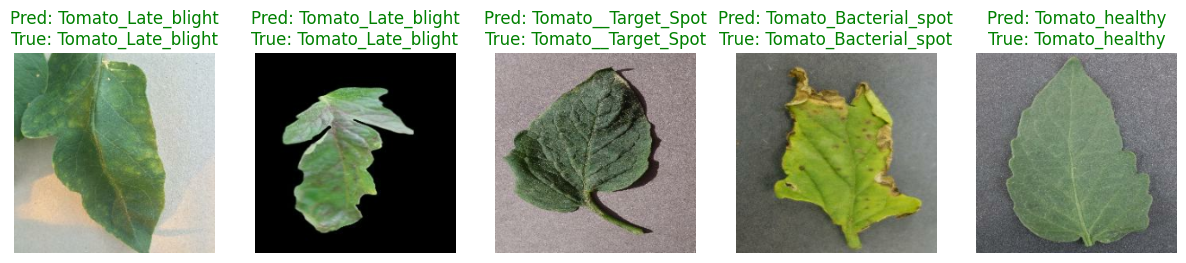

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Get class names from earlier
class_names = class_names  # (already defined before)
print("Classes:", class_names)

# ✅ Take 1 batch of test data
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 8))
    for i in range(5):  # Show 5 random images
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        actual = class_names[labels[i]]
        predicted = class_names[pred_labels[i]]
        color = "green" if actual == predicted else "red"
        plt.title(f"Pred: {predicted}\nTrue: {actual}", color=color)
        plt.axis("off")
    plt.show()
    break  # only one batch


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
1/1 [==============================] - 0s 354ms/step


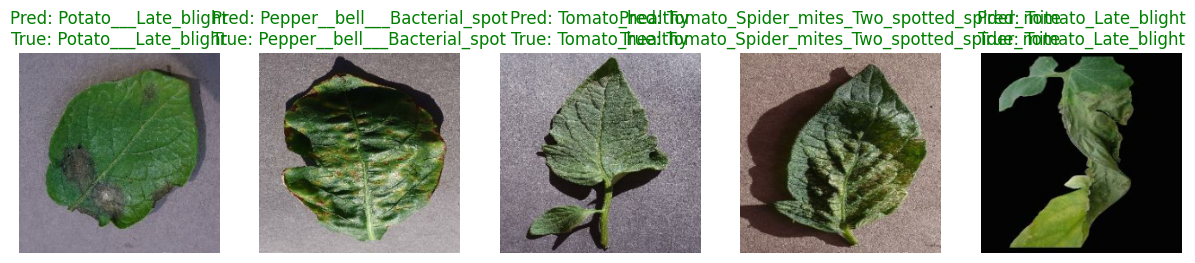

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Get class names from earlier
class_names = class_names  # (already defined before)
print("Classes:", class_names)

# ✅ Take 1 batch of test data
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 8))
    for i in range(5):  # Show 5 random images
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        actual = class_names[labels[i]]
        predicted = class_names[pred_labels[i]]
        color = "green" if actual == predicted else "red"
        plt.title(f"Pred: {predicted}\nTrue: {actual}", color=color)
        plt.axis("off")
    plt.show()
    break  

Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
1/1 [==============================] - 0s 409ms/step


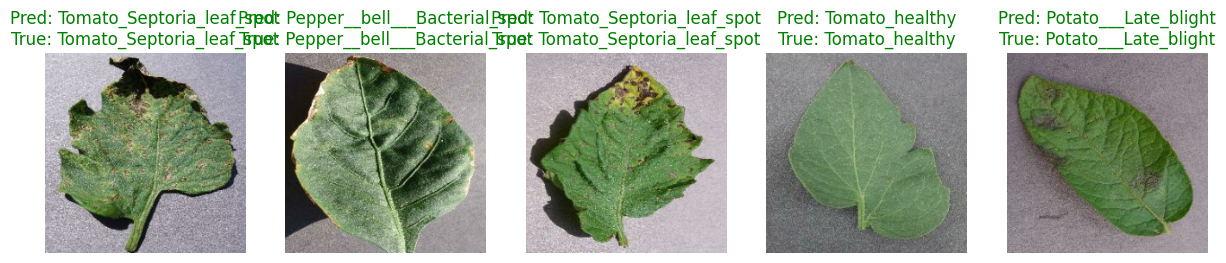

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ Get class names from earlier
class_names = class_names  # (already defined before)
print("Classes:", class_names)

# ✅ Take 1 batch of test data
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 8))
    for i in range(5):  # Show 5 random images
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        actual = class_names[labels[i]]
        predicted = class_names[pred_labels[i]]
        color = "green" if actual == predicted else "red"
        plt.title(f"Pred: {predicted}\nTrue: {actual}", color=color)
        plt.axis("off")
    plt.show()
    break  # only

# Plot training performance

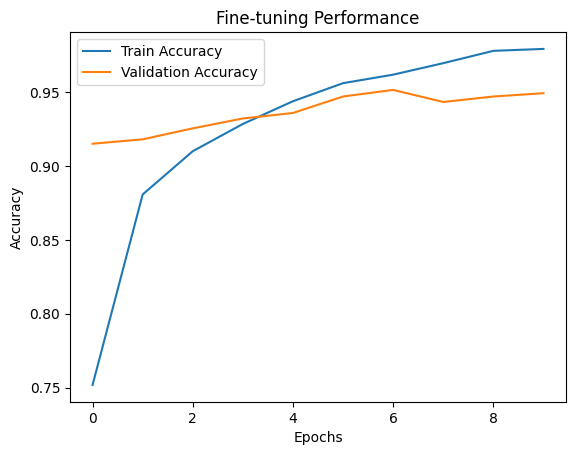

In [21]:
import matplotlib.pyplot as plt

plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Fine-tuning Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [27]:
import numpy as np
from tensorflow.keras.preprocessing import image

# ✅ List your sample test images and their correct class labels
sample_images = [
    ("../data/cleaned/PlantVillage/Tomato_Bacterial_spot/testimg2.jpg", "Tomato_Bacterial_spot"),
    ("../data/cleaned/PlantVillage/Tomato_Early_blight/testimg2.jpg", "Tomato_Early_blight"),
    ("../data/cleaned/PlantVillage/Tomato_healthy/testimg2.jpg", "Tomato_healthy"),
    ("../data/cleaned/PlantVillage/Potato___Late_blight/testimg2.jpg", "Potato___Late_blight"),
    ("../data/cleaned/PlantVillage/Pepper__bell___healthy/testimg2.jpg", "Pepper__bell___healthy"),
]

correct = 0

for img_path, true_label in sample_images:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])
    predicted_label = class_names[class_idx]

    print(f"🖼️ Image: {os.path.basename(img_path)}")
    print(f"✅ True: {true_label}")
    print(f"🤖 Predicted: {predicted_label}")
    print("—" * 40)

    if predicted_label == true_label:
        correct += 1

# ✅ Calculate sample accuracy
sample_accuracy = (correct / len(sample_images)) * 100
print(f"🎯 Sample Test Accuracy (on 5 images): {sample_accuracy:.2f}%")


1/1 [==============================] - 0s 53ms/step
🖼️ Image: testimg2.jpg
✅ True: Tomato_Bacterial_spot
🤖 Predicted: Tomato_Bacterial_spot
————————————————————————————————————————
1/1 [==============================] - 0s 49ms/step
🖼️ Image: testimg2.jpg
✅ True: Tomato_Early_blight
🤖 Predicted: Tomato_Early_blight
————————————————————————————————————————
1/1 [==============================] - 0s 40ms/step
🖼️ Image: testimg2.jpg
✅ True: Tomato_healthy
🤖 Predicted: Tomato_healthy
————————————————————————————————————————
1/1 [==============================] - 0s 47ms/step
🖼️ Image: testimg2.jpg
✅ True: Potato___Late_blight
🤖 Predicted: Potato___Late_blight
————————————————————————————————————————
1/1 [==============================] - 0s 51ms/step
🖼️ Image: testimg2.jpg
✅ True: Pepper__bell___healthy
🤖 Predicted: Pepper__bell___healthy
————————————————————————————————————————
🎯 Sample Test Accuracy (on 5 images): 100.00%


In [28]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

img_path = "../data/raw/PlantVillage/PlantVillage/Tomato_Bacterial_spot/image_new.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_idx = np.argmax(pred[0])
predicted_label = class_names[class_idx]

print(f"Predicted class: {predicted_label}")


1/1 [==============================] - 0s 178ms/step
Predicted class: Tomato_Bacterial_spot


In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

img_path = "../data/raw/PlantVillage/PlantVillage/Tomato_Bacterial_spot/img_new2.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_idx = np.argmax(pred[0])
predicted_label = class_names[class_idx]

print(f"Predicted class: {predicted_label}")


1/1 [==============================] - 0s 107ms/step
Predicted class: Tomato_Bacterial_spot


In [30]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

img_path = "../data/raw/PlantVillage/PlantVillage/Tomato_Leaf_Mold/test_img2.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_idx = np.argmax(pred[0])
predicted_label = class_names[class_idx]

print(f"Predicted class: {predicted_label}")


1/1 [==============================] - 0s 96ms/step
Predicted class: Tomato_Leaf_Mold


In [3]:
from tensorflow.keras.models import load_model
model = load_model("../models/mobilenetv2_final.h5")
print("✅ Loaded model with 91% validation accuracy")



✅ Loaded model with 91% validation accuracy


In [9]:
from tensorflow.keras.preprocessing import image
import numpy as np
import os

img_path = "../data/cleaned/PlantVillage/Tomato_healthy/testimg2.jpg"
class_names = sorted(os.listdir("../data/cleaned/PlantVillage"))

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_idx = np.argmax(pred[0])
predicted_label = class_names[class_idx]

print(f"Predicted class: {predicted_label}")

1/1 [==============================] - 0s 97ms/step
Predicted class: Tomato_healthy
